This notebook is used to prototype different models for predicting voter turnout.

In [1]:
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

import os
import pandas as pd
import pickle
import time

import matplotlib.pyplot as plt
%matplotlib inline

First, I read in the data.

In [2]:
# Read in training data
data_train = pd.read_csv(os.path.join('data', 'train_2008.csv'))

# Extract input features and output labels
X_train = data_train.values[:, 1:-1]
y_train = data_train.values[:, -1]

# Define training set for hyperparameter selection
inds = np.arange(len(X_train))[:10000]
X = X_train[inds]
y = y_train[inds]

I then train random forest classifiers, including hyperparameter selection.

In [3]:
# Specify hyperparameters for tuning
parameters = {'n_estimators': np.arange(1000, 3100, 100),
              'max_features': np.arange(15, 65, 5),
              'min_samples_leaf': np.arange(0.0001, 0.005, 0.0001),
              'max_depth': [None] + list(np.arange(10, 55, 5))}

# Perform hyperparameter testing
clf = RandomizedSearchCV(RandomForestClassifier(), parameters,
                         scoring='roc_auc', return_train_score=True,
                         n_iter=10, n_jobs=-1)
clf.fit(X, y)

# Save results
filename = 'RandomForest_{:s}.pkl'.format(time.strftime('%Y%m%d-%H%M'))
#with open(filename, 'wb') as file:
#    pickle.dump(clf, file)

I read in the results, extract the best estimator, and train it to the full training data.  This final model is then used to make predictions on the test sets.

In [4]:
# Specify file name
#filename = ''

# Read in results
#with open(filename, 'rb') as file:
#    clf = pickle.load(file)

# Train best estimator
model = clf.best_estimator_
model.fit(X_train, y_train)

# Show score on training set
print('ROC AUC (training):',
      roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))

# Read in input data for test sets
test_2008 = pd.read_csv(os.path.join('data', 'test_2008.csv'))
test_2012 = pd.read_csv(os.path.join('data', 'test_2012.csv'))

# Make predictions on test sets
pred_2008 = model.predict_proba(test_2008.values[:, 1:])[:, 1]
pred_2012 = model.predict_proba(test_2012.values[:, 1:])[:, 1]

# Write results
df_2008 = pd.DataFrame(data={'id': test_2008.values[:, 0],
                             'target': pred_2008})
df_2008.to_csv(os.path.join('predictions', 'pred_2008_CS.csv'),
               index=None, header=True)
df_2012 = pd.DataFrame(data={'id': test_2012.values[:, 0],
                             'target': pred_2012})
df_2012.to_csv(os.path.join('predictions', 'pred_2012_CS.csv'),
               index=None, header=True)

ROC AUC (training): 0.7925537920915184


We can use this trained model to extract feature importances.

In [5]:
# Specify file name
filename = 'RandomForest_20190211-0525.pkl'

# Read in results
with open(filename, 'rb') as file:
    _, _, clf = pickle.load(file)

features = data_train.columns[1:-1]
importances = clf.feature_importances_
inds = np.argsort(-importances)
feature_importances = pd.DataFrame(data={'importance': importances[inds]},
                                   index=features[inds])

We examine the top features and their importances.

In [6]:
feature_importances

,importance
PEEDUCA,0.132349
PEAGE,0.063656
HETENURE,0.042779
HUFAMINC,0.038618
QSTNUM,0.021533
PERRP,0.020787
PEIO1OCD,0.018445
GESTCEN,0.017623
PXGRPROF,0.017202
HWHHWGT,0.017076


We also examine the effect of a few key features on the target of interest, starting with education.

Value	Voting Probability
31	0.2636363636363636
32	0.42990654205607476
33	0.47702407002188185
34	0.4860655737704918
35	0.4584269662921348
36	0.4538123167155425
37	0.4716565767749037
38	0.5107913669064749
39	0.654984654984655
40	0.7698831079532432
41	0.7942099755842343
42	0.8290519877675842
43	0.890212835894486
44	0.929370475981575
45	0.9210266535044422
46	0.9316005471956225


(0, 1)

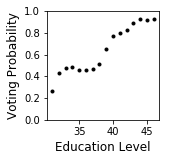

In [7]:
feature = 'PEEDUCA'
vals = np.unique(data_train[feature])
probs = []

# Compute probability of voting for each value of feature
print('Value\tVoting Probability')
for val in vals:
    vote_y = sum((data_train[feature] == val) & (data_train['target'] == 0))
    vote_n = sum((data_train[feature] == val) & (data_train['target'] == 1))
    probs.append(vote_y / (vote_y + vote_n))
    print(val, probs[-1], sep='\t')

# Plot results
plt.figure(figsize=(2, 2))
plt.plot(vals, probs, 'k.')
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Voting Probability', fontsize=12)
plt.ylim([0, 1])

We then repeat this analysis for age.

Value	Voting Probability
18	0.5206463195691203
19	0.5334018499486125
20	0.561025641025641
21	0.5821501014198783
22	0.6061606160616062
23	0.6260543580131209
24	0.6174089068825911
25	0.611984282907662
26	0.6443798449612403
27	0.6729810568295115
28	0.6492395437262357
29	0.6608784473953013
30	0.6897621509824199
31	0.6711798839458414
32	0.678173719376392
33	0.6977687626774848
34	0.7080808080808081
35	0.7003929273084479
36	0.7017873941674506
37	0.7205199628597957
38	0.7593856655290102
39	0.7665805340223945
40	0.7284287011807448
41	0.7392449517120281
42	0.733567046450482
43	0.748932536293766
44	0.7474020783373302
45	0.7742663656884876
46	0.7787676317743133
47	0.7735703245749613
48	0.7694013303769401
49	0.7809885931558935
50	0.7718910963944077
51	0.7646153846153846
52	0.7905918057663126
53	0.8001605136436597
54	0.8098537336412626
55	0.824812030075188
56	0.8260530421216848
57	0.7953020134228188
58	0.8180227471566054
59	0.8274647887323944
60	0.8141980718667835
61	0.8299492385786802
62	0.82359081

(0, 1)

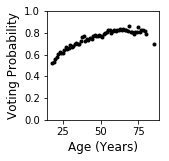

In [8]:
feature = 'PEAGE'
vals = np.unique(data_train[feature])
probs = []

# Compute probability of voting for each value of feature
print('Value\tVoting Probability')
for val in vals:
    vote_y = sum((data_train[feature] == val) & (data_train['target'] == 0))
    vote_n = sum((data_train[feature] == val) & (data_train['target'] == 1))
    probs.append(vote_y / (vote_y + vote_n))
    print(val, probs[-1], sep='\t')

# Plot results
plt.figure(figsize=(2, 2))
plt.plot(vals, probs, 'k.')
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Voting Probability', fontsize=12)
plt.ylim([0, 1])

I also note experiments with other modeling choices that were not used for the final training, including the following:
- Scaling the input data
- Resampling the input data for balanced classes
- Performing feature selection using Yitong's features (code not shown)
- Using logistic regression model

In [ ]:
from sklearn import preprocessing

# Scale data
X = preprocessing.scale(X_train)

In [ ]:
# Resample data to represent both classes equally
inds_neg = np.where(y_train == 0)[0]
inds_pos = np.where(y_train == 1)[0]
inds = np.concatenate((inds_neg,
                       np.random.choice(inds_pos, size=len(inds_neg),
                                        replace=True)))
np.random.shuffle(inds)
X = X_train[inds]
y = y_train[inds]

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression model with different regularization strengths
parameters = {'C': np.logspace(-2, 2, 9)}
clf = RandomizedSearchCV(LogisticRegression(), parameters,
                         scoring='roc_auc', return_train_score=True,
                         n_iter=1, n_jobs=-1)
clf.fit(X, y)

In [ ]:
[(clf.cv_results_['params'][i], clf.cv_results_['mean_test_score'][i])
 for i in np.argsort(clf.cv_results_['rank_test_score'])]